In [74]:
import wotan
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wotan import flatten
from wotan import t14
import lightkurve as lk
import os 
from transitleastsquares import transitleastsquares, cleaned_array, transit_mask
plt.rcParams['figure.dpi'] = 200

In [69]:
import matplotlib
print(matplotlib.__version__)

3.3.0


In [ ]:
"""
Broken axis example, where the x-axis will have a portion cut out.
"""
import matplotlib.pylab as plt
import numpy as np


x = np.linspace(0,10,100)
x[75:] = np.linspace(40,42.5,25)

y = np.sin(x)

f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')

# plot the same data on both axes
ax.plot(x, y)
ax2.plot(x, y)

ax.set_xlim(0,7.5)
ax2.set_xlim(40,42.5)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labelright='off')
ax2.yaxis.tick_right()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.show()

In [17]:
def make_new_plot(raw_lc, detrendMethod, window_size, plot_color): 
    raw_times = raw_lc.time.value
    raw_fluxes = raw_lc.flux.value
    flatten_lc, trend_lc = flatten(
    raw_times,          
    raw_fluxes,                 
    method=detrendMethod,
    window_length=window_size,   
    break_tolerance=0.5,  
    return_trend=True
    )

    mosaic = """
        AA
        BB
        CD
        """

    fig = plt.figure(constrained_layout=True, figsize=(12,6))

    ax_dict = fig.subplot_mosaic(mosaic)

    ax = ax_dict['A']

    ax.scatter(raw_times, raw_fluxes, s=1, color='black')
    ax.plot(raw_times, trend_lc, linewidth=2, color=plot_color)
    ax.set(title='Raw')


    ax = ax_dict['B']
    
    ax.scatter(raw_times, flatten_lc, s=1, color='black')
    
    ax.set(title='Detrended')

    ax = ax_dict['C']

    lc_mean = np.nanmean(flatten_lc)
    lc_std = np.nanstd(flatten_lc)

    upper_lim = lc_mean+2*np.nanstd(flatten_lc)
    mask = np.where(flatten_lc<upper_lim)

    sigma_clipped_times = raw_times[mask]
    sigma_clipped_fluxes = flatten_lc[mask]

    lc_mean = np.nanmean(flatten_lc)
    lc_std = np.nanstd(flatten_lc)

    lower_lim = lc_mean-3*lc_std

    mask = np.where(flatten_lc>lower_lim)

    sigma_clipped_times = raw_times[mask]
    sigma_clipped_fluxes = flatten_lc[mask]

    ax.scatter(sigma_clipped_times, sigma_clipped_fluxes, s=1, color='black')
    
    ax.set(title=r'$1-\sigma$'+' Clipped Detrended')


    

    plt.subplots_adjust(hspace=0.5)

In [77]:
def recover_au_mic(raw_lc, detrendMethod, window_size,plot_color): 
    raw_times = raw_lc.time.value
    raw_fluxes = raw_lc.flux.value
    flatten_lc, trend_lc = flatten(
    raw_times,          
    raw_fluxes,                 
    method=detrendMethod,
    window_length=window_size,   
    break_tolerance=0.5,  
    return_trend=True
    )

    fig, axs = plt.subplots(3,1, figsize=(9,6), sharex=True)

    ax = axs[0]

    ax.scatter(raw_times, raw_fluxes, s=1, color='black')
    ax.plot(raw_times, trend_lc, linewidth=2, color=plot_color)
    ax.set(title='Raw')

    ax = axs[1]
    
    ax.scatter(raw_times, flatten_lc, s=1, color='black')
    
    ax.set(title='Detrended')

    ax = axs[2]

    lc_mean = np.nanmean(flatten_lc)
    lc_std = np.nanstd(flatten_lc)

    upper_lim = lc_mean+2*lc_std
    mask = np.where(flatten_lc<upper_lim)

    sigma_clipped_times = raw_times[mask]
    sigma_clipped_fluxes = flatten_lc[mask]

    '''
    lc_mean = np.nanmean(sigma_clipped_fluxes)

    lower_lim = lc_mean-5*lc_std

    mask = np.where(sigma_clipped_fluxes>lower_lim)

    sigma_clipped_times = sigma_clipped_times[mask]
    sigma_clipped_fluxes = sigma_clipped_fluxes[mask]
    '''

    ax.scatter(sigma_clipped_times, sigma_clipped_fluxes, s=1, color='black')
    
    ax.set(title=r'$1-\sigma$'+' Clipped Detrended')



    for i in range(3): 
        axs[i].set_xlabel('Time (d)')
        if i>0: 
            axs[i].set_ylabel('Normalized Flux')
            axs[i].axhline(y=upper_lim, lw=0.5)
        else: 
            axs[i].set_ylabel('Flux')


    plt.subplots_adjust(hspace=0.5)
    plt.savefig('./plots/general_lightcurves.png')

    plt.clf()
    plt.close()

    t = sigma_clipped_times
    flux = sigma_clipped_fluxes

    for i in range(10): 
        model = transitleastsquares(t, flux)
        results = model.power(use_threads=4, n_transits_min=3, show_progress_bar=False, verbose=False)

        # make iteration dir
        iteration_dir = './plots/iteration_'+str(i)
        
        if not os.path.exists(iteration_dir): 
            os.mkdir(iteration_dir)

        # save periodogram 

        plt.figure()
        ax = plt.gca()
        ax.axvline(results.period, alpha=0.4, lw=3)
        plt.xlim(np.min(results.periods), np.max(results.periods))
        for n in range(2, 10):
            ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
            ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
        plt.ylabel(r'SDE')
        plt.xlabel('Period (days)')
        plt.plot(results.periods, results.power, color='black', lw=0.5)
        plt.xlim(0, max(results.periods))

        plt.savefig(iteration_dir+'/periodogram.png')
        plt.clf()
        plt.close()

        # phase fold top period and save results to csv 

        plt.figure()
        plt.plot(
            results.model_folded_phase,
            results.model_folded_model,
            color='red')
        plt.scatter(
            results.folded_phase,
            results.folded_y,
            color='blue',
            s=10,
            alpha=0.5,
            zorder=2)
        plt.xlim(0.48, 0.52)
        plt.xlabel('Phase')
        plt.ylabel('Relative flux')

        plt.savefig(iteration_dir+'/phase_folded.png')
        plt.clf()
        plt.close()

        intransit = transit_mask(t, results.period, 2*results.duration, results.T0)
        y_second_run = flux[~intransit]
        t_second_run = t[~intransit]
        t, flux = cleaned_array(t_second_run, y_second_run)

In [78]:
# Download AU Mic's light curve
raw_lc = lk.search_lightcurve('TIC 441420236').download()

recover_au_mic(raw_lc, 'ridge',.01,"red")
#make_new_plot(raw_lc, 'ridge',.01,"red") # not working cuz it won't update to 3.3

/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 9 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/usr/local/lib/python3.7/dist-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)
/usr/local/lib/python3.7/dist-packages/transitleastsquares/main.py:411: UserWarning: 3 of 7 transits without data. The true period may be twice the given period.
  warnings.warn(text)
/usr/local/lib/python3.7/dist-packages/transitleastsquares/main.py:411: UserWarning: 2 of 4 transits without data. The true period may be twice the given period.
  warnings.warn(text)


## multiple sessions 

In [9]:
full_raw = lk.search_lightcurve('TIC 441420236').download_all()

stiched_raw = full_raw.stitch()

/usr/local/lib/python3.7/dist-packages/lightkurve/collections.py:214: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_bkg', 'sap_flux'}
  LightkurveWarning,


In [10]:
print(full_raw)
test_raw = full_raw[2,8]
test_stiched = test_raw.stitch()

LightCurveCollection of 9 objects:
    0: <TessLightCurve LABEL="TIC 441420236" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 441420236" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 441420236" SECTOR=1 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    3: <TessLightCurve LABEL="TIC 441420236" SECTOR=1 AUTHOR=TASOC FLUX_ORIGIN=flux_raw>
    4: <TessLightCurve LABEL="TIC 441420236" SECTOR=1 AUTHOR=TASOC FLUX_ORIGIN=flux_raw>
    5: <TessLightCurve LABEL="TIC 441420236" SECTOR=27 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 441420236" SECTOR=27 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 441420236" SECTOR=27 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 441420236" SECTOR=27 AUTHOR=QLP FLUX_ORIGIN=sap_flux>


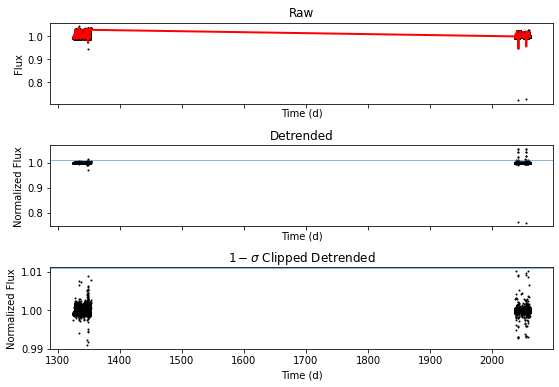

In [55]:
make_plot(test_stiched, 'ridge',.01,"red")